# Plot Flooded Areas (with new class)

In [1]:
from flood_model_paper import *

/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [ ]:
from climada_petals.hazard.rf_glofas.river_flood_computation import RiverFloodInundation
from climada_petals.hazard.rf_glofas.transform_ops import save_file

rf = RiverFloodInundation()
rf.download_reanalysis(
    countries="Pakistan",
    year=2022,
    preprocess=lambda x: x.sel(time=slice("2022-08-01", "2022-08-29")).max(dim="time"),
)
ds_flood = rf.compute()
save_file(ds_flood, DATA_GEN_DIR / "pakistan-flood-220801-220829.nc")

## Compute the Venn data

In [2]:
# Load data and coarsen to appropriate precision (in WGS)

data = gpd.read_file(SATELLITE_WATER_EXTENT_PATH)
data = gpd.GeoSeries(
    shapely.set_precision(data.to_crs(CRS_WGS).geometry, 30 * arcsec), crs=CRS_WGS
)

In [3]:
pakistan_shapefile = gpd.read_file(PAKISTAN_ADMIN2_SHAPEFILE_PATH)

In [4]:
import geopandas as gpd
import xarray as xr

CRS_WGS = "EPSG:4326"  # WGS 84
CRS_EA = "ESRI:54034"  # Cylindrical Equal Area
arcsec = 1 / 60 / 60  # One arcsecond in degrees


def dataarray_to_geodataframe(array: xr.DataArray, threshold=0.0):
    flood_depth = array.squeeze()  # Must be 2D at this point
    df = flood_depth.to_dataframe().reset_index()
    name = array.name
    gdf = gpd.GeoDataFrame(
        df[name],
        geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
        crs=CRS_WGS,
    )
    return gdf[gdf[name] > threshold]


def total_area(gdf: gpd.GeoDataFrame):
    # Buffer the flood points to squares of 15 arcsecond length in lat/lon direction
    return (
        gdf.to_crs(CRS_WGS)
        .geometry.buffer(15 * arcsec, cap_style=3)
        .to_crs(CRS_EA)
        .area.sum()
    )

In [5]:
def is_polygon(geo):
    return shapely.get_dimensions(geo) == 2


def flood_to_geodataframe(dataarray, threshold=0.0):
    flood_depth = dataarray.squeeze()  # Must be 2D at this point
    df = flood_depth.to_dataframe().reset_index()
    name = dataarray.name
    gdf_flood = gpd.GeoDataFrame(
        df[name],
        geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
        crs=CRS_WGS,
    )

    gdf_flood = gdf_flood[gdf_flood[name] > threshold]
    return gdf_flood.sjoin(pakistan_shapefile.to_crs(CRS_WGS))


def buffer_intersection_difference(
    flood: gpd.GeoDataFrame, data: gpd.GeoDataFrame, to_crs=None
):
    # Buffer the flood points to pixels and set precision
    flood = gpd.GeoSeries(
        shapely.set_precision(
            flood.to_crs(CRS_WGS).geometry.buffer(15 * arcsec, cap_style=3), 30 * arcsec
        ),
        crs=CRS_WGS,
    )

    # CRS transform?
    if to_crs is not None:
        flood = flood.to_crs(to_crs)

    # Intersect with shapely
    data_u = data.geometry.to_crs(flood.crs).unary_union
    intersection = gpd.GeoSeries(
        filter(
            is_polygon, shapely.intersection(flood.geometry.unary_union, data_u).geoms
        ),
        crs=flood.crs,
    )
    difference = gpd.GeoSeries(
        filter(
            is_polygon, shapely.difference(flood.geometry.unary_union, data_u).geoms
        ),
        crs=flood.crs,
    )

    return flood, intersection, difference

In [6]:
# Load and transform data

threshold = 0.1  # Minimum flood depth in model
with xr.open_dataset(
    DATA_GEN_DIR / "pakistan-flood-220801-220829.nc", chunks="auto"
) as ds:
    gdf_flood = flood_to_geodataframe(ds["flood_depth"], threshold=threshold)
    flood, intersect, difference = buffer_intersection_difference(
        gdf_flood, data, to_crs=PLOT_CRS
    )
    gdf_flood_flopros = flood_to_geodataframe(
        ds["flood_depth_flopros"], threshold=threshold
    )
    (
        flood_flopros,
        intersect_flopros,
        difference_flopros,
    ) = buffer_intersection_difference(gdf_flood_flopros, data, to_crs=PLOT_CRS)
data = data.to_crs(PLOT_CRS)

/var/folders/fj/w4lbl0pd7l1gcvt664mkfnh00000gq/T/ipykernel_30400/1014820631.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  flood.to_crs(CRS_WGS).geometry.buffer(15 * arcsec, cap_style=3), 30 * arcsec
/var/folders/fj/w4lbl0pd7l1gcvt664mkfnh00000gq/T/ipykernel_30400/1014820631.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  flood.to_crs(CRS_WGS).geometry.buffer(15 * arcsec, cap_style=3), 30 * arcsec


In [7]:
# Areas as GeoSeries
venn = gpd.GeoSeries(
    data=[
        shapely.difference(
            data.geometry.unary_union,
            flood.geometry.unary_union,
        ),
        shapely.difference(
            difference.geometry.unary_union,
            difference_flopros.geometry.unary_union,
        ),
        shapely.difference(
            intersect.geometry.unary_union,
            intersect_flopros.geometry.unary_union,
        ),
        None,
        None,
        shapely.intersection(
            difference.geometry.unary_union,
            difference_flopros.geometry.unary_union,
        ),
        shapely.MultiPolygon(
            filter(
                is_polygon,
                shapely.intersection(
                    flood_flopros.geometry.unary_union,
                    data.geometry.unary_union,
                ).geoms,
            )
        ),
    ],
    index=["Abc", "aBc", "ABc", "abC", "AbC", "aBC", "ABC"],
    crs=PLOT_CRS,
)

In [8]:
# True Negative: Part of flood map, but not flooded in either estimate or data
from climada_petals.hazard.rf_glofas.river_flood_computation import RiverFloodInundation

rf = RiverFloodInundation()
flood_map = rf.flood_maps.isel(return_period=-1).sel(
    longitude=slice(
        ds["flood_depth"].longitude.min() - 1, ds["flood_depth"].longitude.max() + 1
    ),
    latitude=slice(
        ds["flood_depth"].latitude.max() + 1, ds["flood_depth"].latitude.min() - 1
    ),
)
gdf_flood_map = flood_to_geodataframe(flood_map)
flood_map, fm_intersect, fm_difference = buffer_intersection_difference(
    gdf_flood_map, data, to_crs=PLOT_CRS
)

tn = (
    gpd.GeoSeries(
        [
            shapely.difference(
                fm_difference.geometry.unary_union, flood.geometry.unary_union
            )
        ],
        crs=PLOT_CRS,
    )
    .to_crs(CRS_EA)
    .area.sum()
)
tn_flopros = (
    gpd.GeoSeries(
        [
            shapely.difference(
                fm_difference.geometry.unary_union, flood_flopros.geometry.unary_union
            )
        ],
        crs=PLOT_CRS,
    )
    .to_crs(CRS_EA)
    .area.sum()
)
tn, tn_flopros

/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "latitude" starting at index 1377. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "longitude" starting at index 3480. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/var/folders/fj/w4lbl0pd7l1gcvt664mkfnh00000gq/T/ipykernel_30400/1014820631.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  flood.to_crs(CRS_WGS).geometry.buffer(15 * arcsec, cap_style=3), 30 * arcsec


(41403670673.72118, 64339094221.05256)

In [9]:
gpd.GeoSeries(
    [
        shapely.difference(
            flood_map.geometry.unary_union,
            shapely.union(flood.geometry.unary_union, data.geometry.unary_union),
        )
    ],
    crs=PLOT_CRS,
).to_crs(CRS_EA).area.sum()

41403670673.7211

In [10]:
# Area in sqm
area = venn.to_crs(CRS_EA).area
area["VIIRS-NOAA"] = data.geometry.to_crs(CRS_EA).area.sum()
area["Flood"] = flood.geometry.to_crs(CRS_EA).area.sum()
area["Flood FLOPROS"] = flood_flopros.geometry.to_crs(CRS_EA).area.sum()
area["True Negative"] = tn
area["True Negative FLOPROS"] = tn_flopros
area = area.fillna(0)
area

Abc                      3.752651e+10
aBc                      2.293542e+10
ABc                      1.372124e+10
abC                      0.000000e+00
AbC                      0.000000e+00
aBC                      3.394574e+10
ABC                      3.550439e+10
VIIRS-NOAA               8.675214e+10
Flood                    1.061068e+11
Flood FLOPROS            6.945013e+10
True Negative            4.140367e+10
True Negative FLOPROS    6.433909e+10
dtype: float64

### Binary classification

In [11]:
tp = area["ABc"] + area["ABC"]
tp_flopros = area["ABC"]

fp = area["aBc"] + area["aBC"]
fp_flopros = area["aBC"]

fn = area["Abc"]
fn_flopros = area["Abc"] + area["ABc"]

tn = area["True Negative"]
tn_flopros = area["True Negative FLOPROS"]

df = pd.DataFrame(
    data={
        "Precision": [tp / (tp + fp), tp_flopros / (tp_flopros + fp_flopros)],
        "Recall": [tp / (tp + fn), tp_flopros / (tp_flopros + fn_flopros)],
        "Specificity (TNR)": [tn / (tn + fp), tn_flopros / (tn_flopros + fp_flopros)],
        "Accuracy": [
            (tn + tp) / (tn + tp + fn + fp),
            (tn_flopros + tp_flopros)
            / (tn_flopros + tp_flopros + fn_flopros + fp_flopros),
        ],
        "Critical Success Index": [
            tp / (tp + fn + fp),
            tp_flopros / (tp_flopros + fn_flopros + fp_flopros),
        ],
        "Matthews Correlation Coefficient": [
            (tp * tn - fp * fn)
            / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)),
            (tp_flopros * tn_flopros - fp_flopros * fn_flopros)
            / np.sqrt(
                (tp_flopros + fp_flopros)
                * (tp_flopros + fn_flopros)
                * (tn_flopros + fp_flopros)
                * (tn_flopros + fn_flopros)
            ),
        ],
    },
    index=pd.Index(["No Protection", "FLOPROS"]),
)
df["F1 Score"] = 2 * (df["Precision"] * df["Recall"]) / (df["Precision"] + df["Recall"])

# df[["Precision", "Recall"]] = df[["Precision", "Recall"]] * 100
# df[["Precision", "Recall"]] = df[["Precision", "Recall"]].round(1)
# df["F1 Score"] = df["F1 Score"].round(2)
# percent_fmt = "{:0.1f} \%".format
# float_fmt = r"{{:0.2f}}".format
df = df.T
df.to_latex(
    DATA_GEN_DIR / "flood-classification.tex",
    float_format="{:0.2f}".format
    # formatters=[percent_fmt, percent_fmt, str],
)
df.round(2)

No Protection  FLOPROS
Precision                                  0.46     0.51
Recall                                     0.57     0.41
Specificity (TNR)                          0.42     0.65
Accuracy                                   0.49     0.54
Critical Success Index                     0.34     0.29
Matthews Correlation Coefficient          -0.01     0.07
F1 Score                                   0.51     0.45

## Plotting

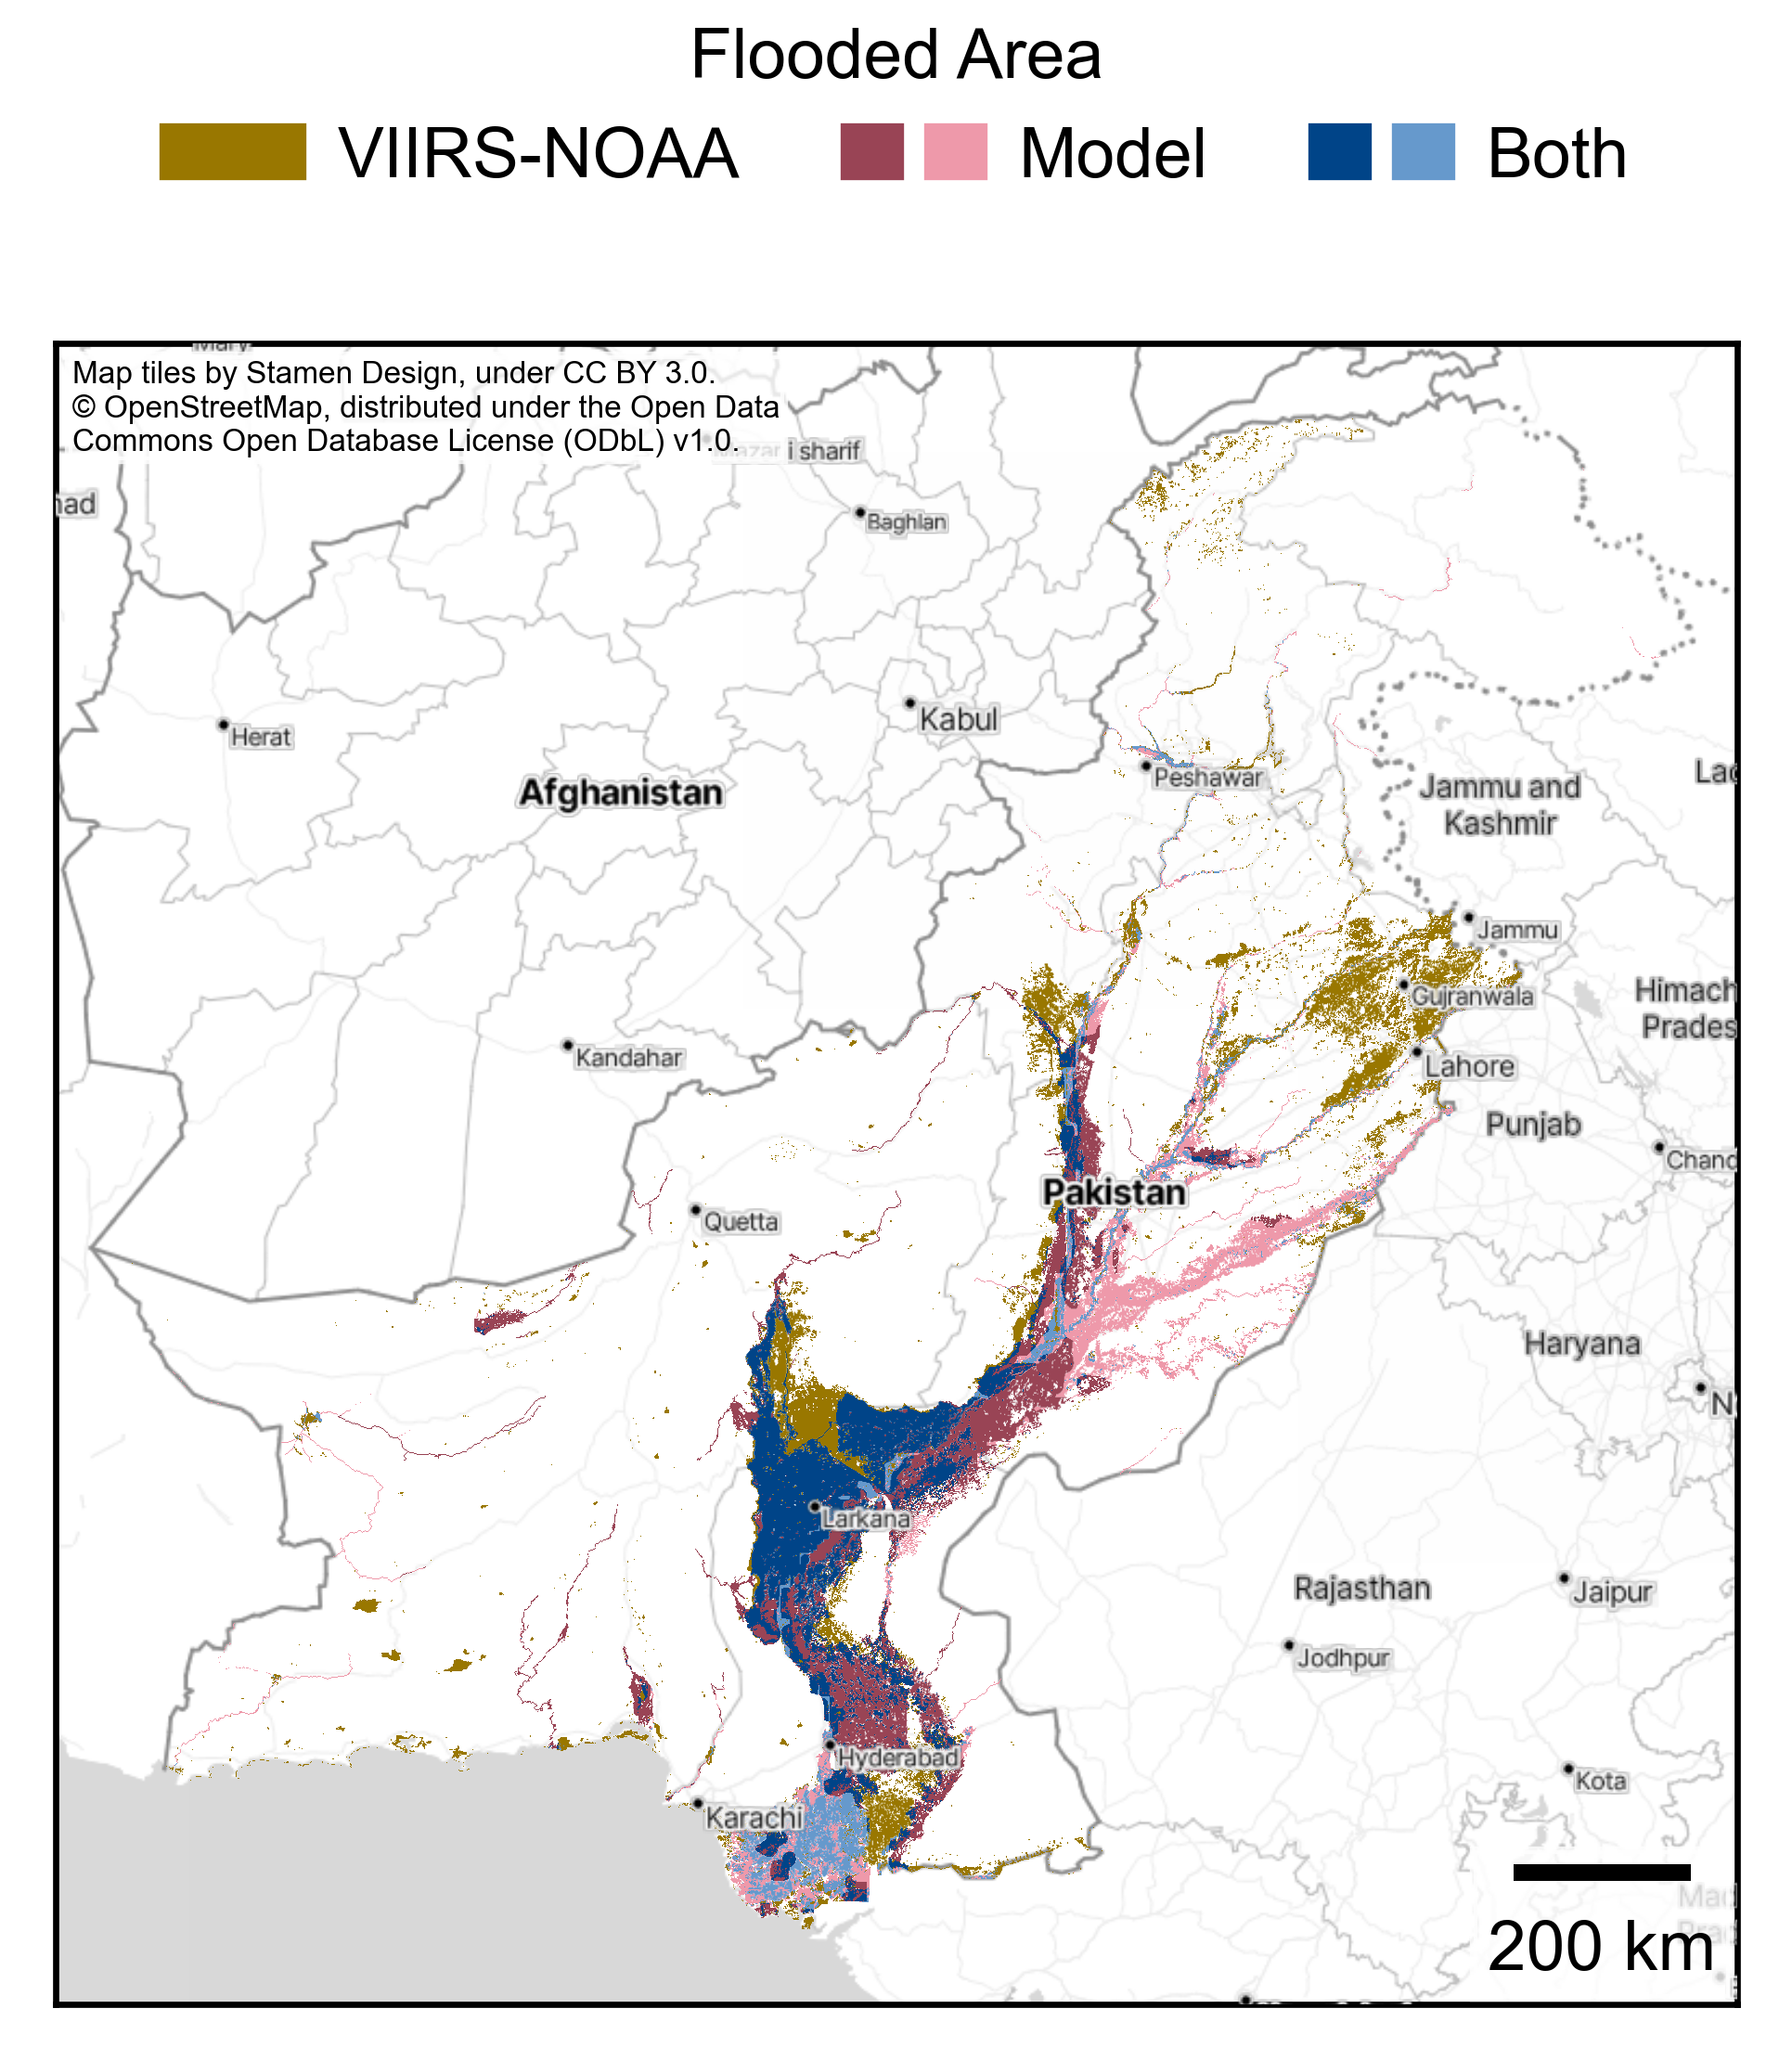

In [12]:
# Test: Areas only
fig, ax = plt.subplots(1, 1, figsize=(FIG_WIDTH_ONE_COL, FIG_HEIGHT))
colors = tol_colors.tol_cset("medium-contrast")

gpd.GeoSeries(venn["aBc"], crs=venn.crs).plot(ax=ax, color=colors.light_red)
gpd.GeoSeries(venn["ABc"], crs=venn.crs).plot(ax=ax, color=colors.light_blue)
gpd.GeoSeries(venn["aBC"], crs=venn.crs).plot(ax=ax, color=colors.dark_red)
gpd.GeoSeries(venn["ABC"], crs=venn.crs).plot(ax=ax, color=colors.dark_blue)
gpd.GeoSeries(venn["Abc"], crs=venn.crs).plot(ax=ax, color=colors.dark_yellow)

remove_ticks(ax)
add_basemap(ax)
add_attribution(fig, loc="top left")

handles = [
    mpatches.Patch(color=colors.dark_yellow),
    (mpatches.Patch(color=colors.dark_red), mpatches.Patch(color=colors.light_red)),
    (
        mpatches.Patch(color=colors.dark_blue),
        mpatches.Patch(color=colors.light_blue),
    ),
]
labels = ["VIIRS-NOAA", "Model", "Both"]

leg = fig.legend(
    title="Flooded Area",
    handles=handles,
    labels=labels,
    numpoints=1,
    handler_map={tuple: HandlerTuple(ndivide=None)},
    loc="outside upper center",
    ncols=len(handles),
    frameon=False,
    handlelength=2,
    borderaxespad=0,
    handletextpad=0.5,
    columnspacing=1.5,
)

add_scalebar(ax)
set_margins(ax)

In [13]:
area = (area / 1e6).round().astype("int")
area

Abc                       37527
aBc                       22935
ABc                       13721
abC                           0
AbC                           0
aBC                       33946
ABC                       35504
VIIRS-NOAA                86752
Flood                    106107
Flood FLOPROS             69450
True Negative             41404
True Negative FLOPROS     64339
dtype: int64

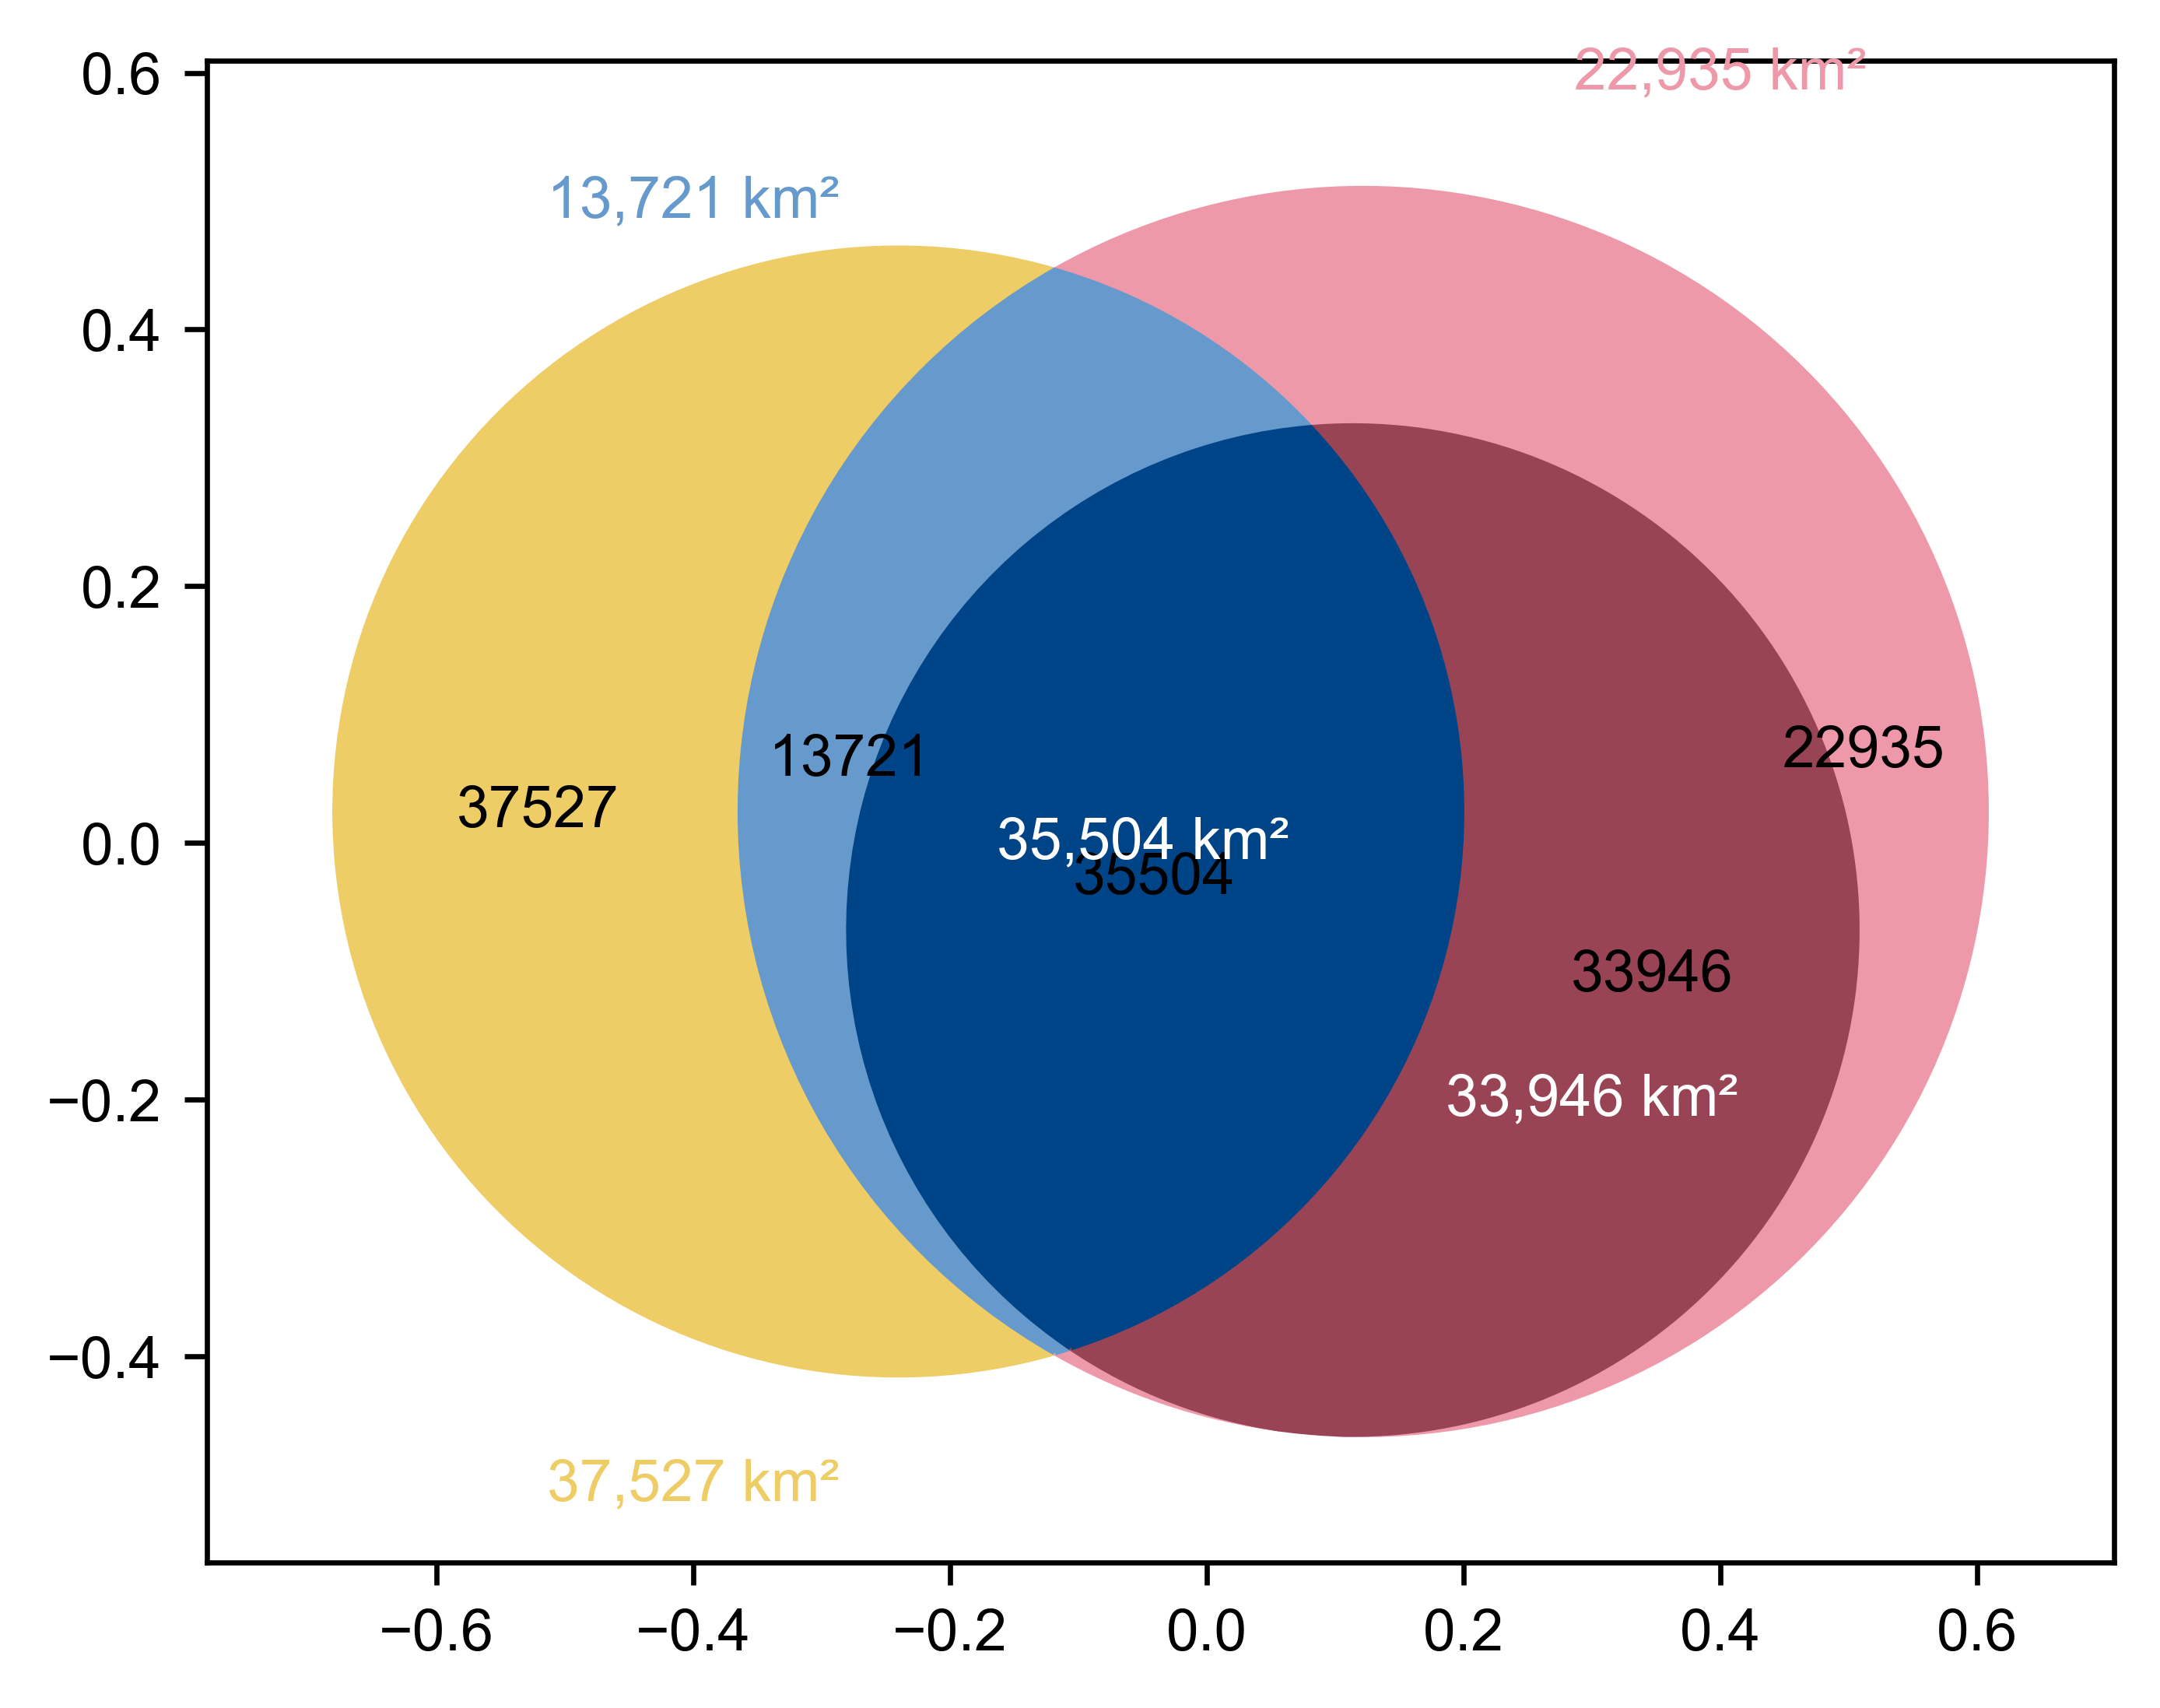

In [14]:
# Test: Venn only

import matplotlib.ticker as mticker
from matplotlib_venn import venn3

fig, ax = plt.subplots(1, 1, figsize=(FIG_WIDTH_TWO_COL, FIG_HEIGHT))
v = venn3(
    ax=ax,
    subsets=(
        area["Abc"],  # Abc
        area["aBc"],  # aBc
        area["ABc"],  # ABc
        area["abC"],  # abC
        area["AbC"],  # AbC
        area["aBC"],  # aBC
        area["ABC"],  # ABC
    ),
    set_labels=None,
)

v.get_patch_by_id("100").set_color(colors.light_yellow)
v.get_patch_by_id("010").set_color(colors.light_red)
v.get_patch_by_id("011").set_color(colors.dark_red)
v.get_patch_by_id("111").set_color(colors.dark_blue)
v.get_patch_by_id("110").set_color(colors.light_blue)
for patch in v.patches:
    if patch is None:
        continue
    patch.set_alpha(1.0)


# Annotations by hand
def fmt(x):
    return f"{int(x):,d} km²"


center_kwargs = dict(ha="center", va="center")

ax.text(-0.05, 0.0, fmt(area["ABC"]), color="white", **center_kwargs)
ax.text(0.3, -0.2, fmt(area["aBC"]), color="white", **center_kwargs)

ax.text(-0.4, 0.5, fmt(area["ABc"]), color=colors.light_blue, **center_kwargs)
ax.text(-0.4, -0.5, fmt(area["Abc"]), color=colors.light_yellow, **center_kwargs)
ax.text(0.4, 0.6, fmt(area["aBc"]), color=colors.light_red, **center_kwargs)

ax.set_axis_on()

ax.xaxis.set_major_locator(mticker.AutoLocator())
ax.yaxis.set_major_locator(mticker.AutoLocator())

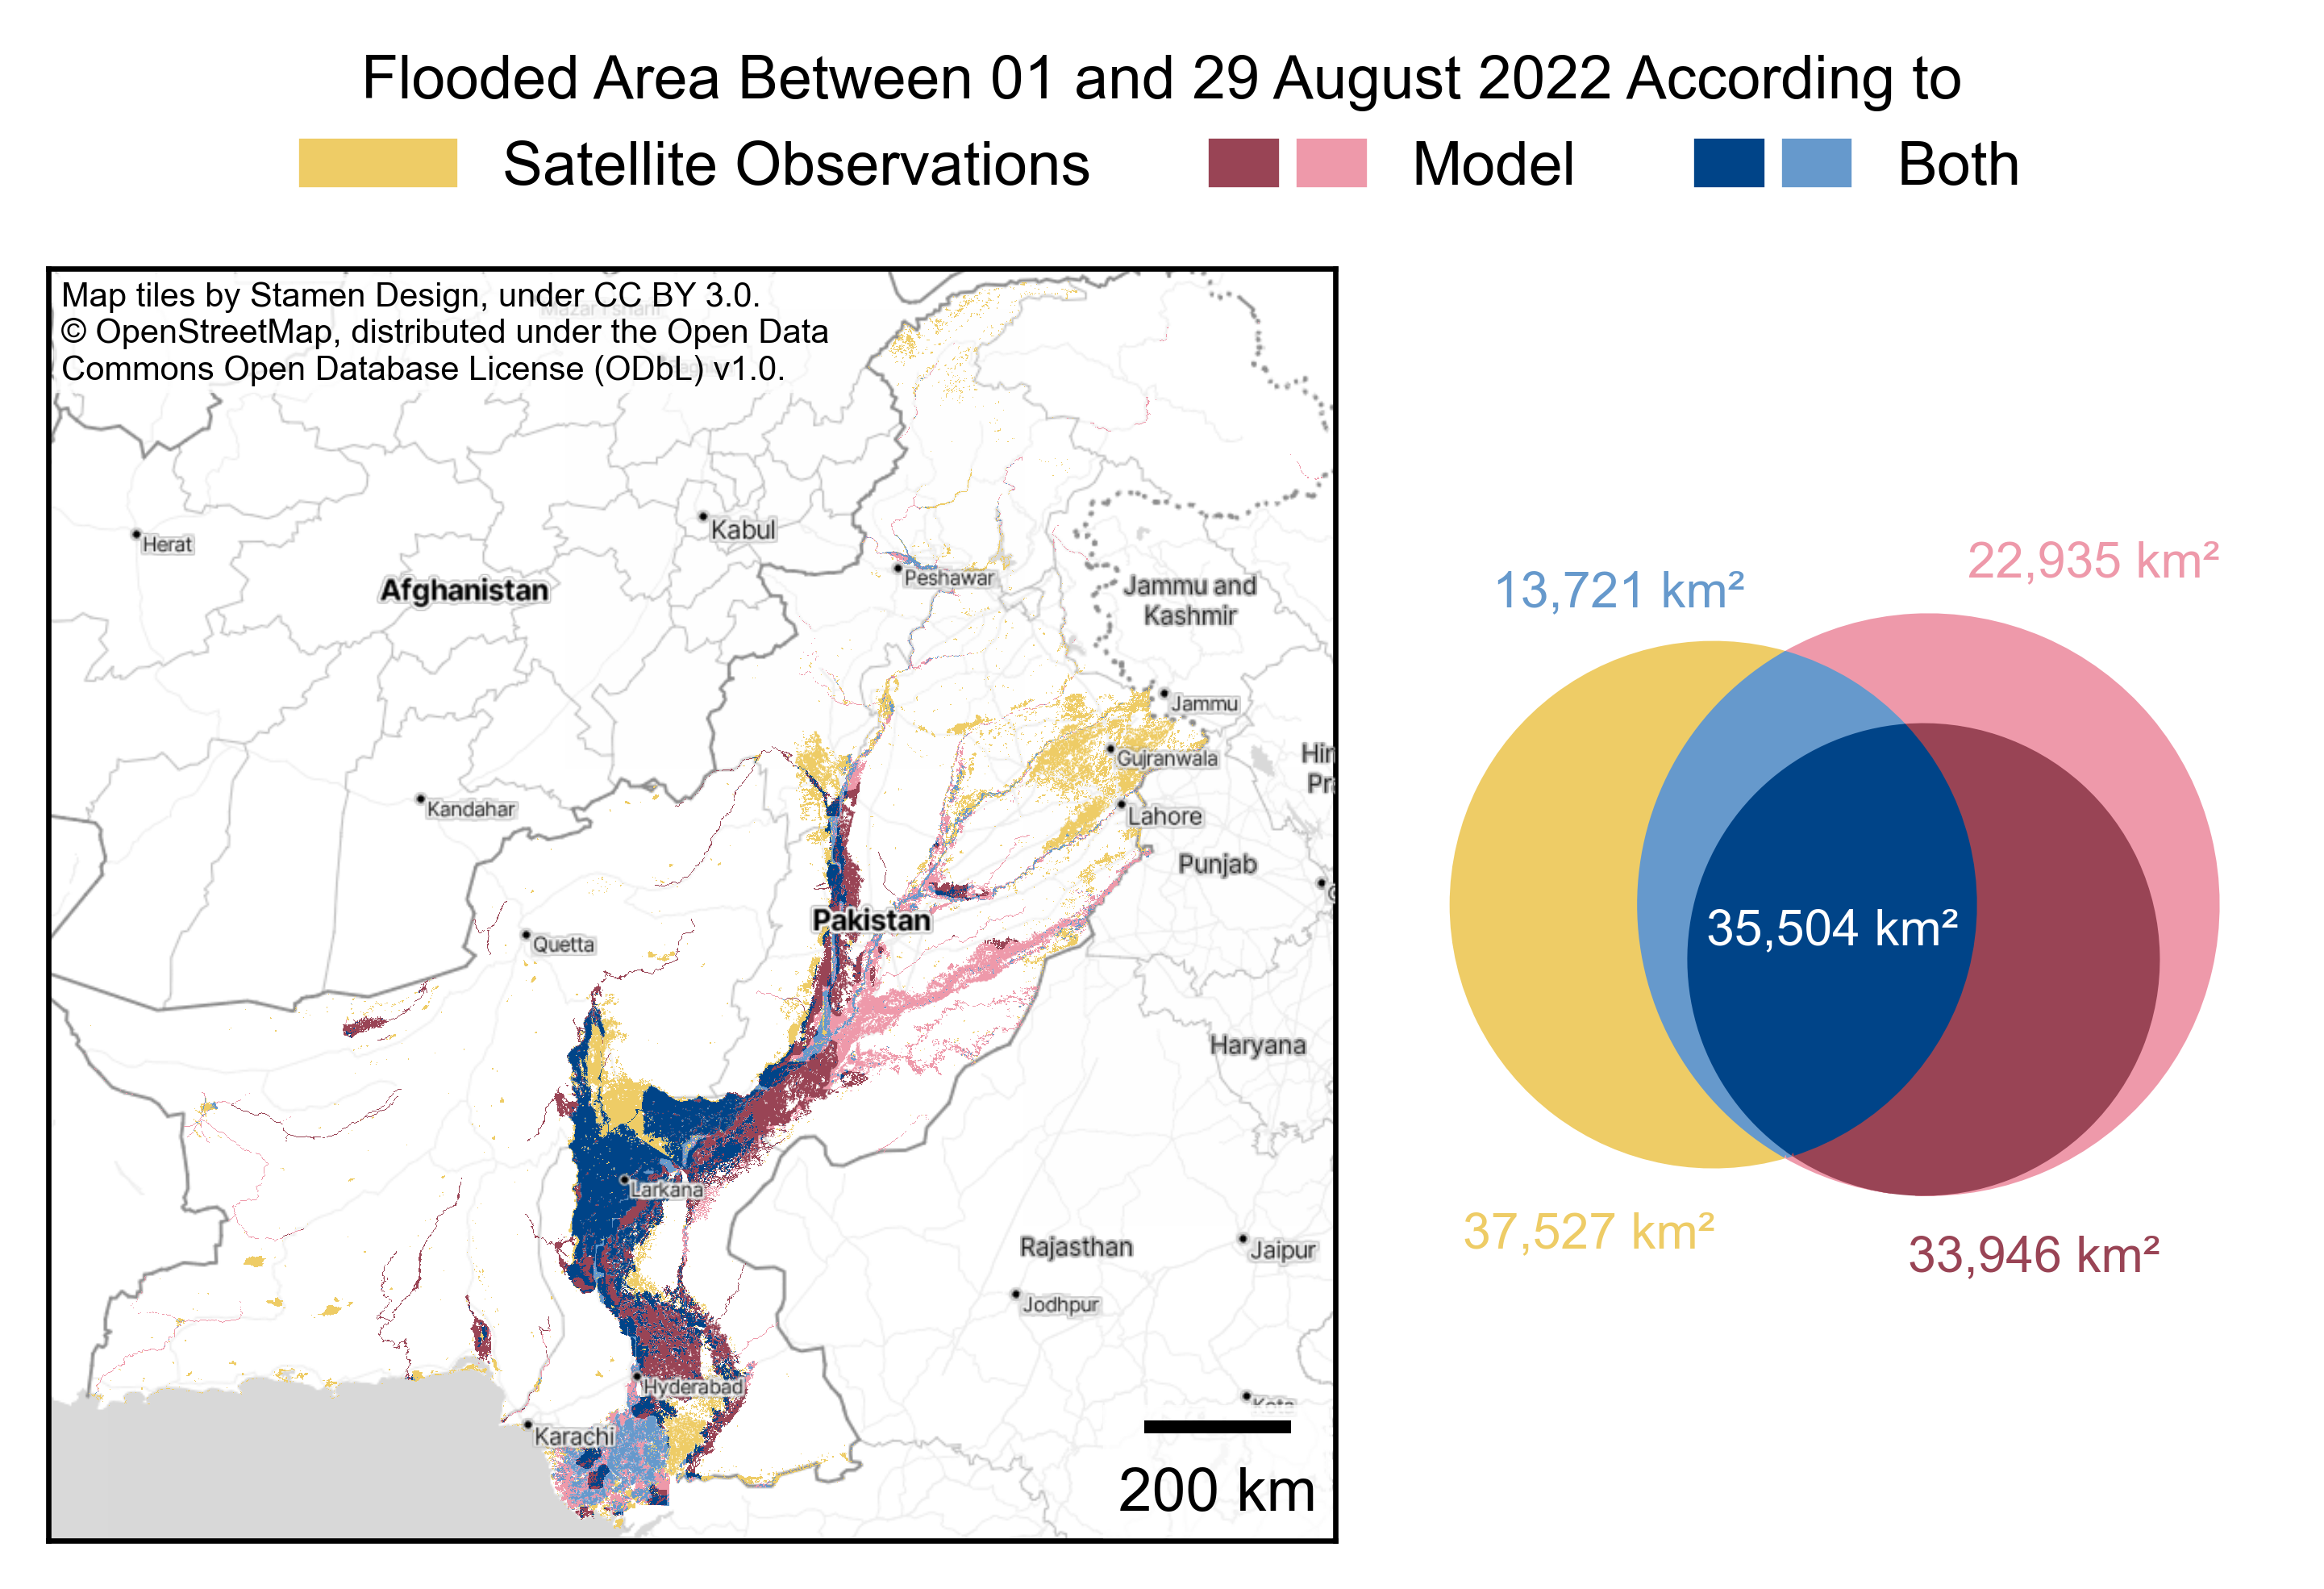

In [17]:
# Plot: All

BASEMAP_DEFAULT = "carto"

fig, axes = plt.subplots(
    1,
    2,
    figsize=(FIG_WIDTH_TWO_COL, FIG_HEIGHT * 0.9),
    gridspec_kw=dict(width_ratios=[3, 2]),
)
colors = tol_colors.tol_cset("medium-contrast")

set_margins(fig)

gpd.GeoSeries(venn["aBc"], crs=venn.crs).plot(ax=axes[0], color=colors.light_red)
gpd.GeoSeries(venn["ABc"], crs=venn.crs).plot(ax=axes[0], color=colors.light_blue)
gpd.GeoSeries(venn["aBC"], crs=venn.crs).plot(ax=axes[0], color=colors.dark_red)
gpd.GeoSeries(venn["ABC"], crs=venn.crs).plot(ax=axes[0], color=colors.dark_blue)
gpd.GeoSeries(venn["Abc"], crs=venn.crs).plot(ax=axes[0], color=colors.light_yellow)

add_basemap(axes[0])
remove_ticks(axes[0])
add_attribution(axes[0], "top")
add_scalebar(axes[0])

handles = [
    mpatches.Patch(color=colors.light_yellow),
    (mpatches.Patch(color=colors.dark_red), mpatches.Patch(color=colors.light_red)),
    (
        mpatches.Patch(color=colors.dark_blue),
        mpatches.Patch(color=colors.light_blue),
    ),
]
labels = ["Satellite Observations", "Model", "Both"]

leg = fig.legend(
    title="Flooded Area Between 01 and 29 August 2022 According to",
    handles=handles,
    labels=labels,
    numpoints=1,
    handler_map={tuple: HandlerTuple(ndivide=None)},
    loc="outside upper center",
    ncols=len(handles),
    frameon=False,
    handlelength=2.5,
    # borderaxespad=0,
    # handletextpad=0.5,
    # columnspacing=1.5,
)
# leg.set_zorder(10)

v = venn3(
    ax=axes[1],
    subsets=(
        area["Abc"],  # Abc
        area["aBc"],  # aBc
        area["ABc"],  # ABc
        area["abC"],  # abC
        area["AbC"],  # AbC
        area["aBC"],  # aBC
        area["ABC"],  # ABC
    ),
    set_labels=None,
    subset_label_formatter=lambda _: "",
    # set_labels=("VIIRS-NOAA", "Flood Model", "Flood Model (FLOPROS)"),
)

v.get_patch_by_id("100").set_color(colors.light_yellow)
v.get_patch_by_id("010").set_color(colors.light_red)
v.get_patch_by_id("011").set_color(colors.dark_red)
v.get_patch_by_id("111").set_color(colors.dark_blue)
v.get_patch_by_id("110").set_color(colors.light_blue)
for patch in v.patches:
    if patch is None:
        continue
    patch.set_alpha(1.0)


# Annotations by hand
def fmt(x):
    return f"{int(x):,d} km²"


text_kwargs = dict(ha="center", va="center", fontsize="small")

axes[1].text(-0.04, -0.02, fmt(area["ABC"]), color="white", **text_kwargs)
axes[1].text(0.3, -0.57, fmt(area["aBC"]), color=colors.dark_red, **text_kwargs)

axes[1].text(-0.4, 0.55, fmt(area["ABc"]), color=colors.light_blue, **text_kwargs)
axes[1].text(-0.45, -0.53, fmt(area["Abc"]), color=colors.light_yellow, **text_kwargs)
axes[1].text(0.4, 0.6, fmt(area["aBc"]), color=colors.light_red, **text_kwargs)

fig.savefig("flooded-area.pdf")